# ML Experiment

This is a notebook for running a machine learning experiment. Text and comments in this notebook will be kept to a minimum, as this notebook is supposed to serve as a dashboard of modules-sorts. This notebook aims to contain/achieve the following for any experiment:
- Import relevant data (splitting, resizing and pre-run processing should be achieved via other notebooks)
- Load trained model (optional) OR build, compile model here (no real need to save empty models)
- Analysis
- Save trained model (optional if deemed usable later, save model with weights)
- Export experiment folder containing plots, info, model reference, thumbnails
- Log the experiment in the log file

In [1]:
# ============================================================================ #
#
#    ML experiment notebook (Nayani lab)
#    Author: Prateek Verma
#    Courtesy: None
#    Created on: Dec 18, 2021
#
# ============================================================================ #

import pvPackage as pv
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import shutil
# import matplotlib.patheffects as pEffects

## Experiment information

Add basic information about the experiment, that can potentially be logged/saved.

In [3]:
# ============================================================================ #
#    EXPERIMENT CONSTANTS (CHANGE THESE)
# ============================================================================ #

# IMPORTANT: Set an EXPERIMENT & STUDY ID here if they're already known.
# -------------------------------------------------------------------- #
# Most other things are decided based on whether the ID exists or not.

EXP_ID = '00009' # leave as an empty string if new id should be created
STUDY_ID = '01'
STUDY_FOLDER = pv.core.get_glob_paths_list('../Studies', '*' + STUDY_ID + '*')

#    if start of a new experiment (MODIFY THESE)
# -------------------------------------------------------------------- #
if EXP_ID == '':
    # generate a new experiment id
    EXP_ID = pv.core.get_next_id(STUDY_FOLDER, removePrefix='E ', lenID=5, fileOrDir='dir')
    EXP_NAME = 'classifying chicken vs human unstrained RBCs using polarized micrographs'
    EXP_SHORT_NAME = 'chicken human unstrained polarized'
    # create an experiment folder path and folder
    EXP_FOLDER = Path(STUDY_FOLDER, 'E ' + EXP_ID + ' ' + EXP_SHORT_NAME)
    EXP_FOLDER.mkdir()
    IMAGE_SIZE = (500, 500)
    BATCH_SIZE = 32
    LEARNING_RATE = 0.0001
    MODEL_ID = '00002'
    USE_TRAINED_MODEL = False # just to be certain the flag is set properly
    OVERWRITE = True # hack to save certain files only when new experiment. Note that we are not checking for existing files (like plots) before we save them. This flag is simpler right now.

#    if continuing an old experiment
# -------------------------------------------------------------------- #
else:
    # set the experiment folder path to the existing one
    EXP_FOLDER = pv.core.get_glob_paths_list(STUDY_FOLDER, '*' + EXP_ID + '*')
    # see if a description file exists
    if Path(EXP_FOLDER, 'description.txt').is_file() == False:
        print('ERROR: Experiment folder or description file not found.')
    else:
    # read the description file and gather experiment info
        with open(Path(EXP_FOLDER, 'description.txt'), 'r') as descFyle:
            for n, line in enumerate(descFyle):
                if n == 2:
                    DATASET_ID = line.split('=')[1].strip().split(' ')[1]
                if n == 3:
                    IMAGE_SIZE = line.split('=')[1].strip().strip('()').split(',')
                    IMAGE_SIZE = (int(IMAGE_SIZE[0].strip()), int(IMAGE_SIZE[1].strip()))
                if n == 4:
                    BATCH_SIZE = int(line.split('=')[1].strip())
                if n == 5:
                    LEARNING_RATE = float(line.split('=')[1].strip())
                if n == 6:
                    EXP_NAME = line.split('=')[1].strip()
                if n == 7:
                    EXP_SHORT_NAME = line.split('=')[1].strip()
                if n == 20:
                    MODEL_ID = line.split('=')[1].strip()
    USE_TRAINED_MODEL = True

# some derived constants
split_dataset_path = pv.core.get_glob_paths_list('../Clean datasets', '*' + DATASET_ID + '*')
dataset_name = split_dataset_path.name.split('(')[1].strip(')')

# some helpful printouts
print('Study folder =', STUDY_FOLDER)
print('Experiment ID =', EXP_ID)
print('Dataset ID =', DATASET_ID)
print('split dataset path =', split_dataset_path)
print('Image size =', IMAGE_SIZE)
print('Batch size =', BATCH_SIZE)
print('Learning rate =', LEARNING_RATE)
print('Model ID =', MODEL_ID)
print('Experiment name =', EXP_NAME)
print('Experiment short name =', EXP_SHORT_NAME)
print('Use trained model?', USE_TRAINED_MODEL)

Study folder = ..\Studies\ST 01 - strained unstrained chicken human RBCs
Experiment ID = 00009
Dataset ID = 00006
split dataset path = ..\Clean datasets\DS 00006 (strained unstrained chicken brightview)
Image size = (500, 500)
Batch size = 32
Learning rate = 0.0001
Model ID = 00002
Experiment name = classifying strained vs unstrained chicken RBCs using unpolarized micrographs
Experiment short name = strained unstrained chicken unpolarized
Use trained model? True


## Import images to memory

We need to import images into the memory before we can use it in the model. Images need to be provided in the way the model wants it.

In [4]:
# create a generator object with desired preprocessing. Here we only do horizontal and vertical flips, and normalize the pixel values
gen = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255, # rescaling is done after all transformations
)
# create training, validation and test data generators. These will be imported during training or whenever the method is called, in batches, indefinitely.
train_gen = gen.flow_from_directory(
    Path(split_dataset_path, 'train'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True, #default seems to be True
    class_mode='binary'
)
val_gen = gen.flow_from_directory(
    Path(split_dataset_path, 'val'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='binary'
)
test_gen = gen.flow_from_directory(
    Path(split_dataset_path, 'test'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='binary'
)
# Print out the class indices (TO LOG)
class_indices = train_gen.class_indices
print(class_indices)
# Print out the number of batches for each of train, val, test
print('No. of TVT batches: ', [len(train_gen), len(val_gen), len(test_gen)])
# print number of TVT images in each class
# calculate TVT sample distribution for each class
tvt_dist = {}
for k, v in class_indices.items():
    tvt_dist[k+' ('+str(v)+')'] = [np.count_nonzero(train_gen.classes == v), np.count_nonzero(val_gen.classes == v), np.count_nonzero(test_gen.classes == v)]
print('TVT sample distribution per class =', tvt_dist)

Found 696 images belonging to 2 classes.
Found 149 images belonging to 2 classes.
Found 149 images belonging to 2 classes.
{'strained chicken brightview': 0, 'unstrained chicken brightview': 1}
No. of TVT batches:  [22, 5, 5]
TVT sample distribution per class = {'strained chicken brightview (0)': [584, 125, 125], 'unstrained chicken brightview (1)': [112, 24, 24]}


### Visualize imported images

In [5]:
# capture the train batch, will be used later too (e.g. visualization)
image_batch, label_batch = train_gen[0]

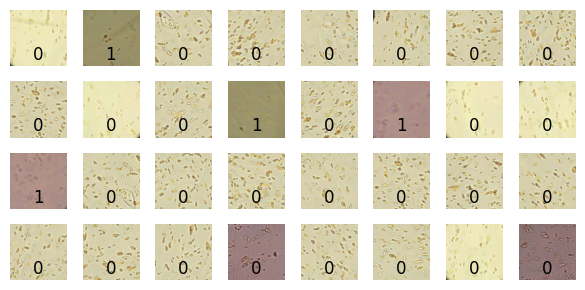

In [16]:
OVERWRITE = True
# convert binary label to either 0 or 1 string
label_batch = [str(int(label)) for label in label_batch]
# saves an image in the folder only if it doesn't exist
pv.core.plot_images_labels(
    image_batch,
    label_batch,
    numColumns=8,
    figWidth=6,
    figExtraHeight=0,
    textPos=(0.5, 0.2),
    fontSize='large',
    fontColor='black',
    savePath=Path(EXP_FOLDER, 'training images sample.png') if OVERWRITE else None,
    styleSheet=['../../_resources/styles/pv.mplstyle']
)

## Import model

Import a model architecture only, or a trained model with weights here.

In [7]:
# ============================================================================ #
#    IMPORTING MODEL ARCHITECTURE
# ============================================================================ #

if USE_TRAINED_MODEL == False:
    model_arc_file = open(pv.core.get_glob_paths_list('../Model architectures', '*'+MODEL_ID+'*.json'), 'r')
    model = tf.keras.models.model_from_json(model_arc_file.read())
    model_arc_file.close()
    model.summary()

In [8]:
# ============================================================================ #
#    IMPORT A TRAINED MODEL AND HISTORY
# ============================================================================ #

if USE_TRAINED_MODEL:
    model = tf.keras.models.load_model(Path(EXP_FOLDER, 'trained_model.h5'))
    history = pd.read_csv(Path(EXP_FOLDER, 'history.csv'), sep='\t')
    model.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d-1 (Conv2D)            (None, 498, 498, 16)      448       
_________________________________________________________________
maxPooling-1 (MaxPooling2D)  (None, 249, 249, 16)      0         
_________________________________________________________________
conv2d-2 (Conv2D)            (None, 247, 247, 32)      4640      
_________________________________________________________________
maxPooling-2 (MaxPooling2D)  (None, 123, 123, 32)      0         
_________________________________________________________________
conv2d-3 (Conv2D)            (None, 121, 121, 64)      18496     
_________________________________________________________________
maxPooling-3 (MaxPooling2D)  (None, 60, 60, 64)        0         
_________________________________________________________________
flatten-1 (Flatten)          (None, 230400)            0       

## Experiment

### Train model

Train the model, if not using an already trained model.

In [9]:
if USE_TRAINED_MODEL == False:
    # compile the model
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss = 'binary_crossentropy',
        metrics = ['accuracy']
        )
    # train/fit the model
    history = model.fit(
        train_gen,
        validation_data = val_gen,
        epochs = 100,
        verbose = 1
    )
    # Let's save the history and model here, so that we don't have to wait until the training is done.
    pd.DataFrame(history.history).to_csv(Path(EXP_FOLDER, 'history.csv'), sep='\t')
    # load it as a dataframe so it can be plotted using the custom plot function
    history = pd.read_csv(Path(EXP_FOLDER, 'history.csv'), sep='\t')
    model.save(Path(EXP_FOLDER, 'trained_model.h5'))

### Plot accuracy
Whether a pretrained model is used or a new model is trained, the history is saved to the experiment folder and will be used to plot the accuracy curve here.

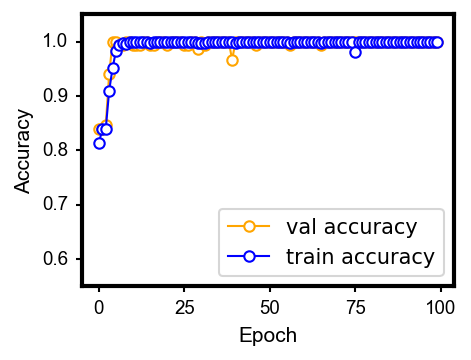

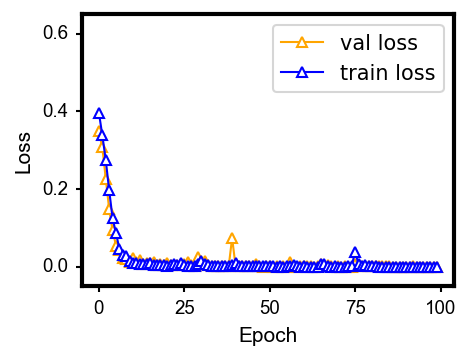

In [10]:
OVERWRITE = True
accuracy_plot = pv.core.plot_simple(
    [history.iloc[:,0]], [history['val_accuracy'], history['accuracy']],
    seriesLabels=['val accuracy', 'train accuracy'], markers=['o', 'o'], colors=['orange', 'blue'],
    xLabel='Epoch', yLabel='Accuracy', title='',
    yLimits=[0.55, 1.05],
    legendLocation='lower right',
    styleSheet=['../../_resources/styles/pv.mplstyle',
                '../../_resources/styles/pv-light.mplstyle',
                '../../_resources/styles/pv-pub-half-width.mplstyle'],
    figSize=(3.2, 2.4),
    savePath=Path(EXP_FOLDER, 'accuracy_plot.png') if OVERWRITE else None,
    saveDPI=300
    )
loss_plot = pv.core.plot_simple(
    [history.iloc[:,0]], [history['val_loss'], history['loss']],
    seriesLabels=['val loss', 'train loss'], markers=['^', '^'], colors=['orange', 'blue'],
    xLabel='Epoch', yLabel='Loss', title='',
    yLimits=[-.05, 0.65],
    legendLocation='upper right',
    styleSheet=['../../_resources/styles/pv.mplstyle',
                '../../_resources/styles/pv-light.mplstyle',
                '../../_resources/styles/pv-pub-half-width.mplstyle'],
    figSize=(3.2, 2.4),
    savePath=Path(EXP_FOLDER, 'loss_plot.png') if OVERWRITE else None,
    saveDPI=300
    )

### ROC curve and confusion matrix

In [11]:
# Find validation and test probabilities
# Note the higher probability is for the '1' class
val_probability = model.predict(x=val_gen, batch_size=8, verbose=0)
test_probability = model.predict(x=test_gen, batch_size=8, verbose=0)

In [12]:
THRESHOLDS = np.linspace(0,1,101)

In [13]:
# Calculate the ROC and CMs for each threshold
cmroc_val = pv.ml.binary_cm_roc(val_probability, val_gen.classes, thresholds=THRESHOLDS)
# Let test set also find its own threshold, although it is better to force the val threshold to the test set
cmroc_test = pv.ml.binary_cm_roc(test_probability, test_gen.classes, thresholds=THRESHOLDS)

# IMPORTANT: use the best threshold obtained from validation and apply the same threshold to the test it. Pass it as a single value inside a list. Adding 0 and 1 to the list, hoping that one of them is not the best threshold, so the plot will be normalized with lines and shit.
cmroc_test_constrained = pv.ml.binary_cm_roc(test_probability, test_gen.classes, thresholds=[0, cmroc_val['best threshold'], 1])
#cmroc_val.keys()

Plot and save the ROC curves.

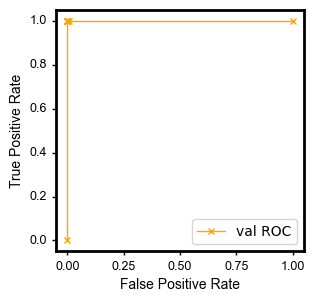

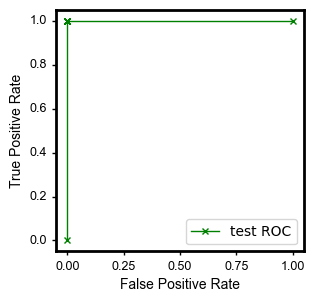

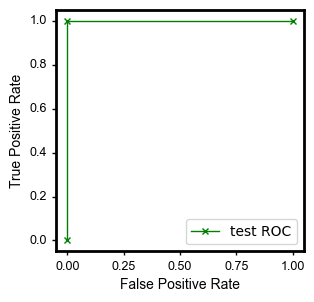

In [14]:
OVERWRITE = True
# plot the ROC curve for val and test sets
# plot separately because they overlap a lot
val_roc_plot = pv.core.plot_simple(
    [cmroc_val['fpr']], [cmroc_val['tpr']], seriesLabels=['val ROC'],
    markers=['x'], colors=['orange'],
    xLabel='False Positive Rate', yLabel='True Positive Rate',
    styleSheet=['../../_resources/styles/pv.mplstyle',
                '../../_resources/styles/pv-light.mplstyle',
                '../../_resources/styles/pv-pub-half-width.mplstyle'],
    figSize=(3.2, 3.2), displayDPI=100,
    savePath=Path(EXP_FOLDER, 'val_roc_plot.png') if OVERWRITE else None, saveDPI=300)

# perhaps plotting ROC dcurve for test set does not make sense, because we are not varying the thresholds, but anyways
test_roc_plot = pv.core.plot_simple(
    [cmroc_test['fpr']], [cmroc_test['tpr']], seriesLabels=['test ROC'],
    markers=['x'], colors=['green'],
    xLabel='False Positive Rate', yLabel='True Positive Rate',
    styleSheet=['../../_resources/styles/pv.mplstyle',
                '../../_resources/styles/pv-light.mplstyle',
                '../../_resources/styles/pv-pub-half-width.mplstyle'],
    figSize=(3.2, 3.2), displayDPI=100,
    savePath=Path(EXP_FOLDER, 'test_roc_plot.png') if OVERWRITE else None, saveDPI=300)

# force val best threshold on to the test set
test_roc_plot_constrained = pv.core.plot_simple(
    [cmroc_test_constrained['fpr']], [cmroc_test_constrained['tpr']], seriesLabels=['test ROC'],
    markers=['x'], colors=['green'],
    xLabel='False Positive Rate', yLabel='True Positive Rate',
    styleSheet=['../../_resources/styles/pv.mplstyle',
                '../../_resources/styles/pv-light.mplstyle',
                '../../_resources/styles/pv-pub-half-width.mplstyle'],
    figSize=(3.2, 3.2), displayDPI=100,
    savePath=Path(EXP_FOLDER, 'test_roc_plot_constrained.png') if OVERWRITE else None, saveDPI=300)

Plot and save the confusion matrices.

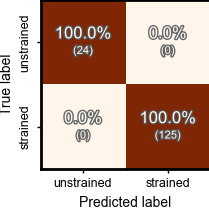

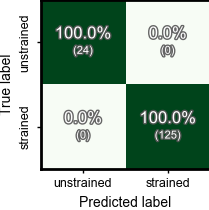

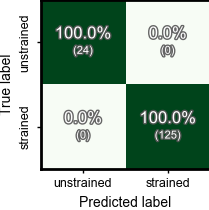

In [17]:
OVERWRITE = True
val_cm_plot = pv.ml.plot_confusion_matrix(
    cmroc_val['best cm'], classes=['unstrained', 'strained'], # carefull with the class names
    savePath=Path(EXP_FOLDER, 'val_cm_plot.png') if OVERWRITE else None,
    displayDpi=100, saveDpi=300,
    cmap=plt.cm.Oranges,
    styleSheet=['../../_resources/styles/pv.mplstyle',
                '../../_resources/styles/pv-light.mplstyle',
                '../../_resources/styles/pv-pub-half-width.mplstyle'],
    xTickRotation=0, yTickRotation=90
)
test_cm_plot = pv.ml.plot_confusion_matrix(
    cmroc_test['best cm'], classes=['unstrained', 'strained'],
    savePath=Path(EXP_FOLDER, 'test_cm_plot.png') if OVERWRITE else None,
    displayDpi=100, saveDpi=300,
    cmap=plt.cm.Greens,
    styleSheet=['../../_resources/styles/pv.mplstyle',
                '../../_resources/styles/pv-light.mplstyle',
                '../../_resources/styles/pv-pub-half-width.mplstyle'],
    xTickRotation=0, yTickRotation=90
)
test_cm_plot_constrained = pv.ml.plot_confusion_matrix(
    cmroc_test_constrained['best cm'], classes=['unstrained', 'strained'],
    savePath=Path(EXP_FOLDER, 'test_cm_plot_constrained.png') if OVERWRITE else None,
    displayDpi=100, saveDpi=300,
    cmap=plt.cm.Greens,
    styleSheet=['../../_resources/styles/pv.mplstyle',
                '../../_resources/styles/pv-light.mplstyle',
                '../../_resources/styles/pv-pub-half-width.mplstyle'],
    xTickRotation=0, yTickRotation=90
)

### Network visualizations

#### Weights/filters visualization

In [20]:
#    Get weights and biases
# -------------------------------------------------------------------- #

# Get weights and biases for the convolutional layers into a list
weights_list = []
biases_list = []
# loop through each layers
for layer in model.layers:
    if 'conv' in layer.name:
        # layer.get_weights() returns tuple of weights and biases
        weights, biases = layer.get_weights()
        # add weights and biases to the list
        # note that individual weights and biases are np arrays, not lists
        weights_list.append(weights)
        biases_list.append(biases)
        # print out the name of the layer and the shape of the weights/biases
        print(layer.name, '>> weights', weights.shape, '>> biases', biases.shape)
print('shown above are the shapes of weights/biases for each layer')

conv2d-1 >> weights (3, 3, 3, 16) >> biases (16,)
conv2d-2 >> weights (3, 3, 16, 32) >> biases (32,)
conv2d-3 >> weights (3, 3, 32, 64) >> biases (64,)
shown above are the shapes of weights/biases for each layer


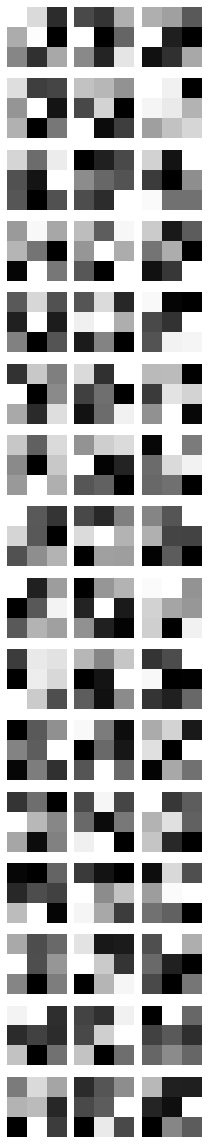

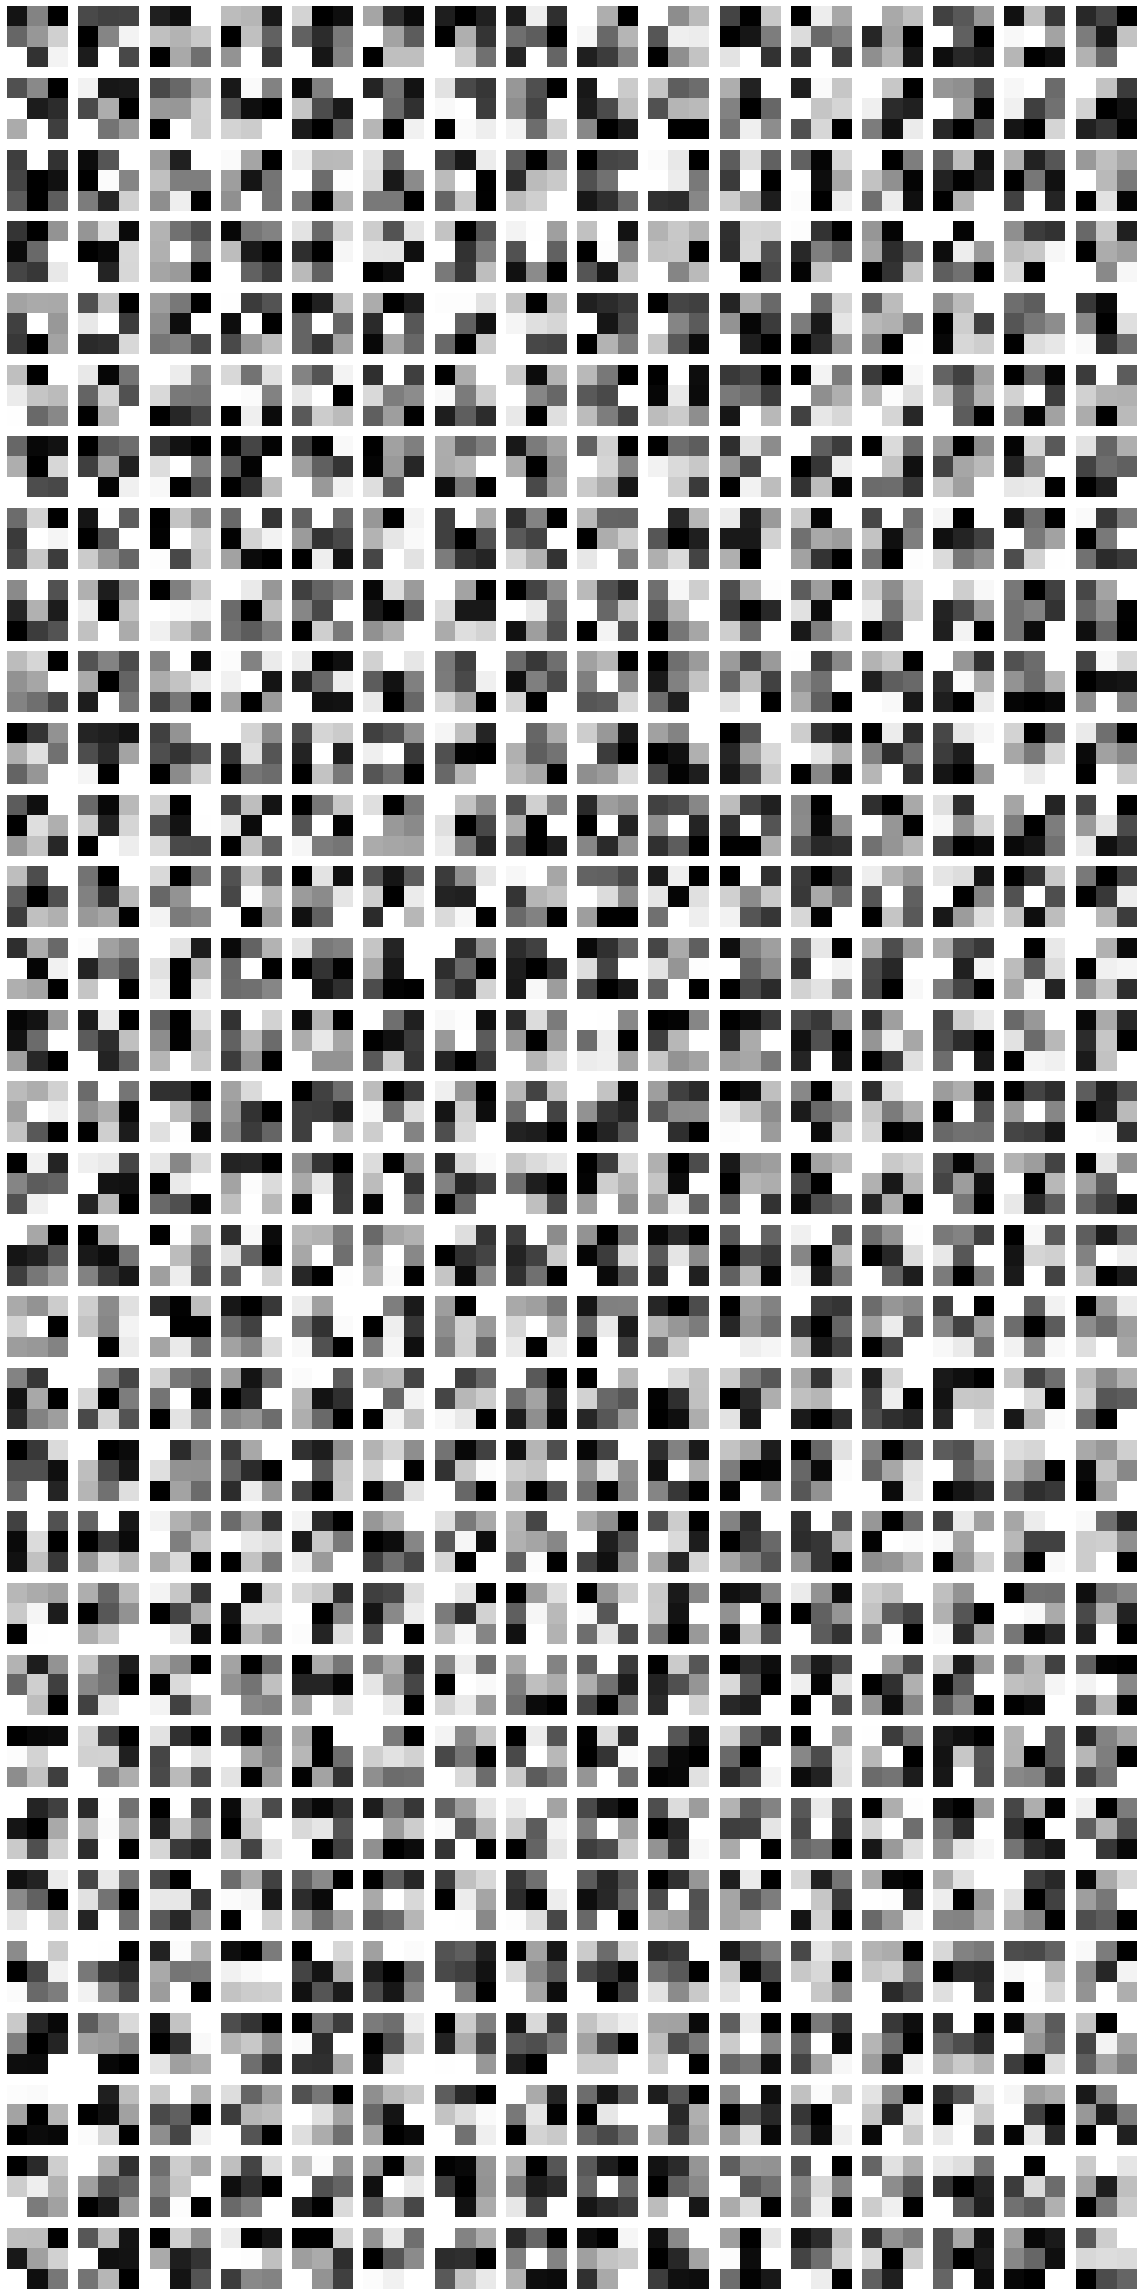

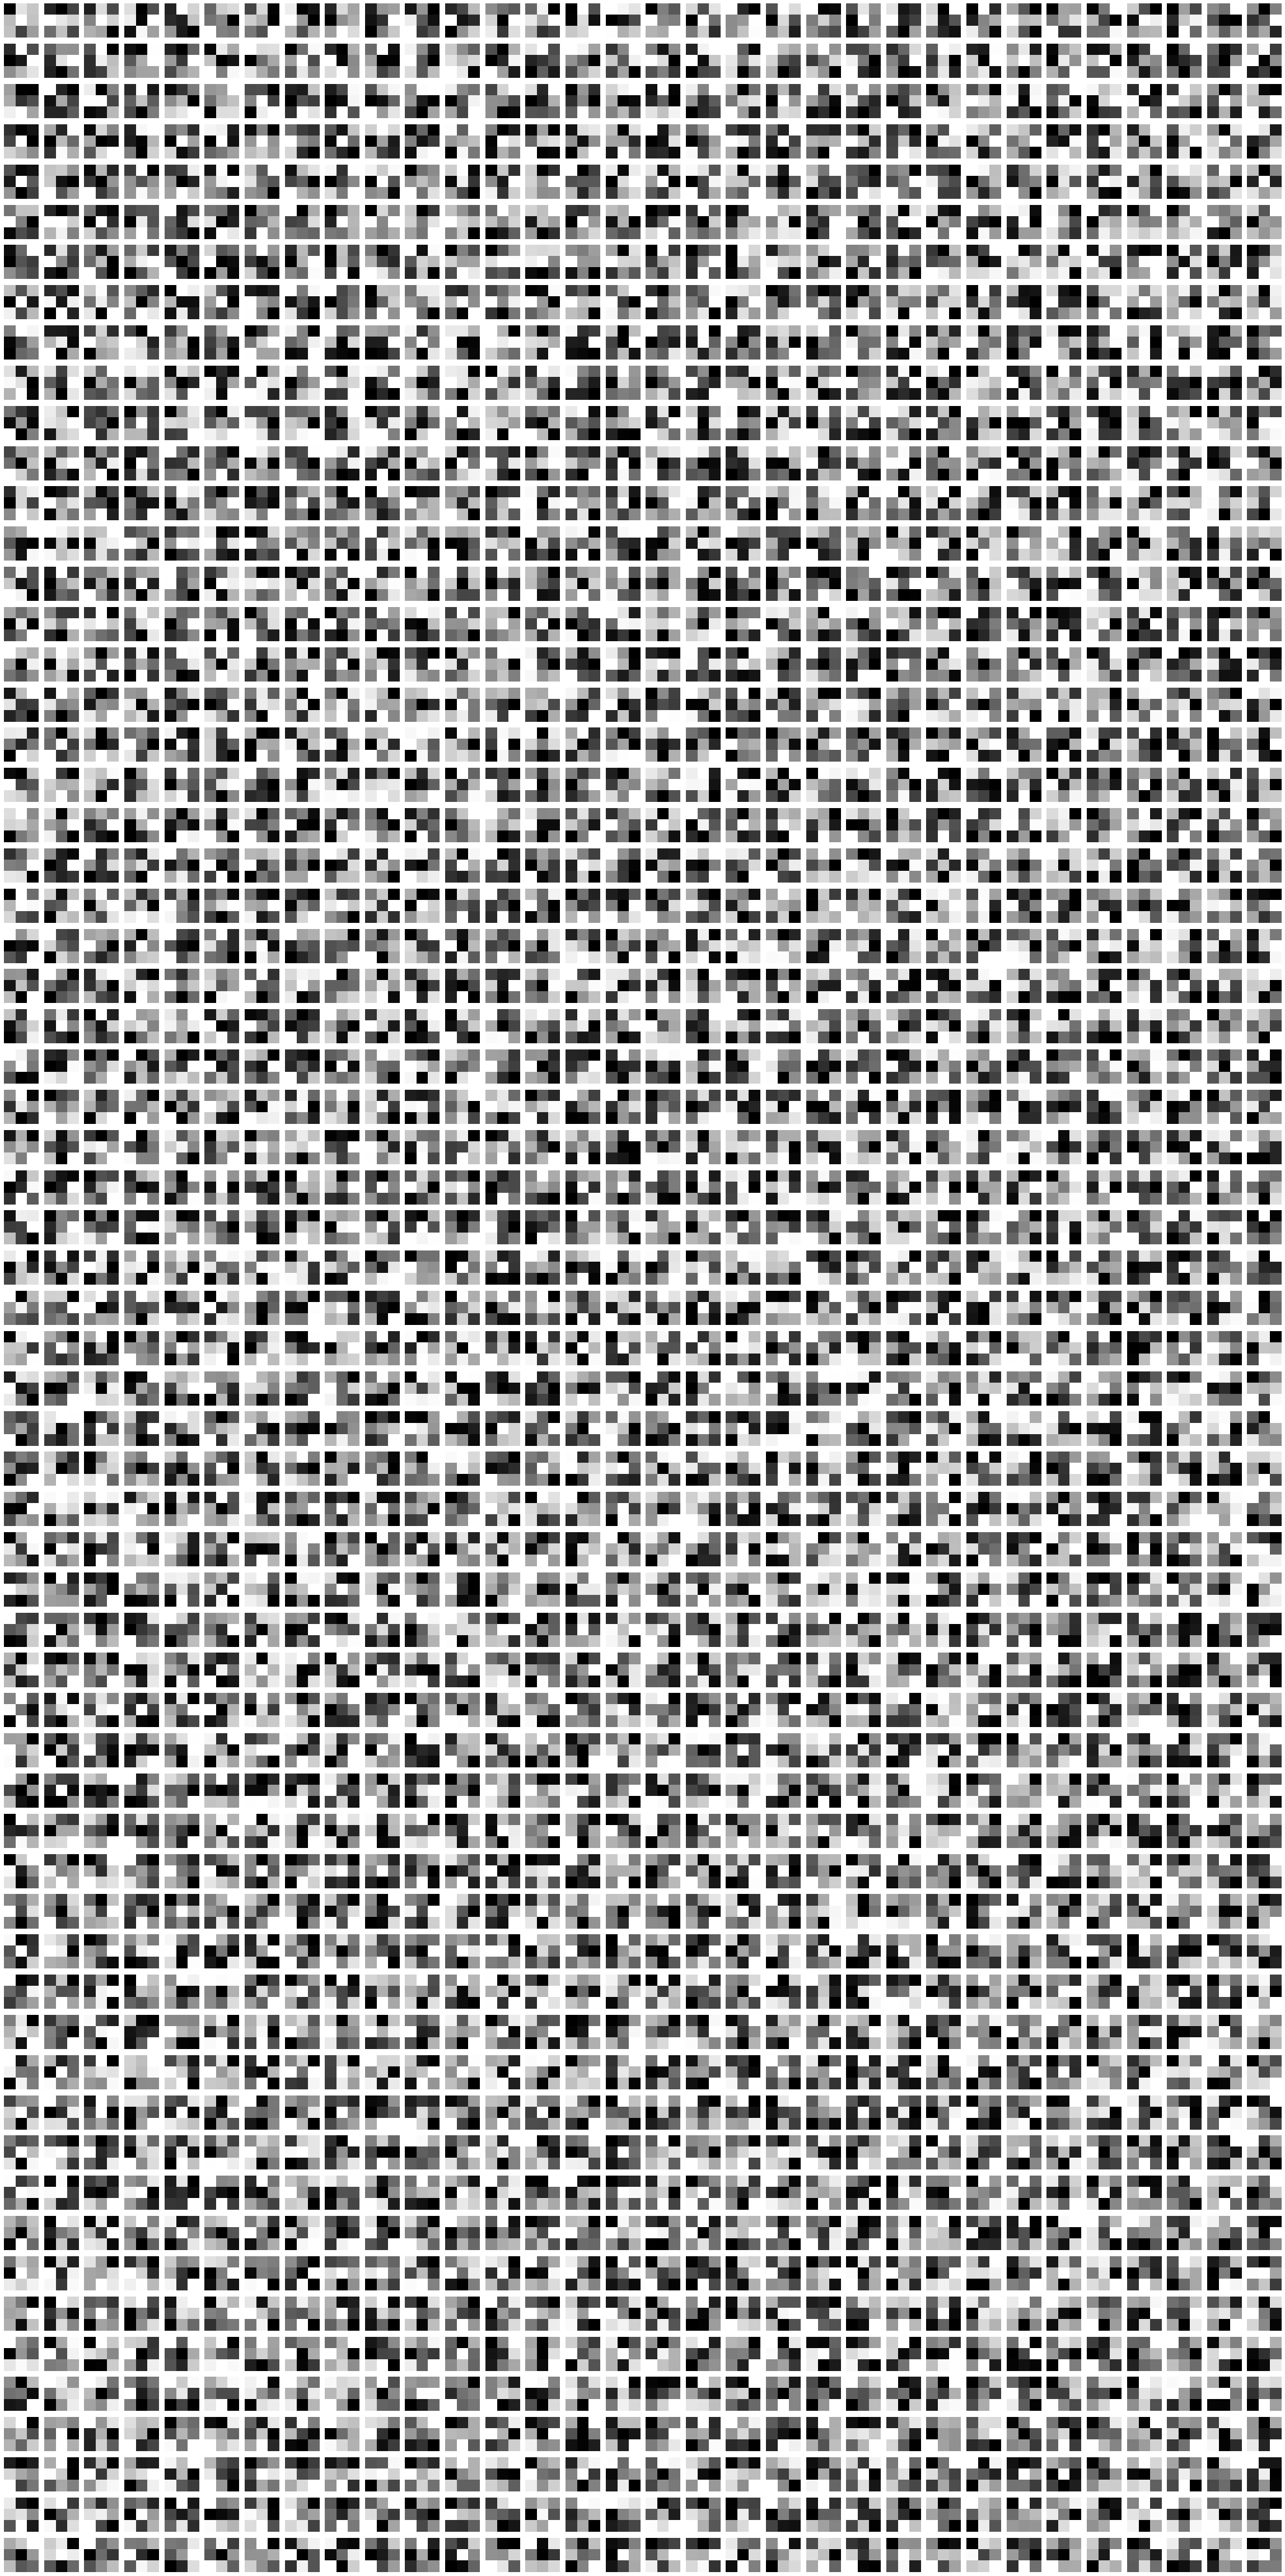

In [21]:
#    Plot all the weights == filters
# -------------------------------------------------------------------- #

OVERWRITE = True
# loop through weights for each layer, in this case 3 weights for 3 layers
for w_l in weights_list:
    
    # notice the dimension of the weights first. It looks like there are 16 filters, each of size 3 x 3 (are these the first two dimensions or the middle two?) and one each for 3 channels (RGB).
    
    # decide figure size, let's put 16 filters vertically and 3 channels horizontally
    plt.figure(figsize=(w_l.shape[-2], w_l.shape[-1])) # (width=3, height=16)
    # note that since subplot location is incremental, it's not possible to recreate it using i and j; how would you create location 7, for example, which is a prime number? Thus we use a counter.
    subplot_loc = 1
    
    # create 48 subplots and move through them
    for i in range(w_l.shape[-1]):
        for j in range(w_l.shape[-2]):
            plt.subplot(w_l.shape[-1], w_l.shape[-2], subplot_loc) # subplots move horizontally it seems, which is good for us.
            plt.imshow(w_l[:,:,j,i], cmap='gray') # plot the filter
            # plt.text(0.5, 0.5, str(i)+','+str(j), fontsize=10) # label the filter
            subplot_loc += 1
            plt.axis('off')
    plt.tight_layout()
    plt.savefig(Path(EXP_FOLDER, 'weights_'+str(w_l.shape[-1])+'x'+str(w_l.shape[-2])+'.png'), dpi=150) if OVERWRITE else None
    plt.show()

#### Features visualization

In [22]:
#    Build submodels
# -------------------------------------------------------------------- #

# Need to build a submodel (a subset of the current model) for up to after the convolutional layer, for each convolutional layer. You can include max-pooling if you wish, but I wish to visualize the output before maxpooling.

submodels_list = [] # holds all submodels, in this case 3 submodels

for layer in model.layers:
    if 'conv' in layer.name:
        # build a submodel for each convolutional layer
        submodel = tf.keras.models.Model(inputs=model.input, outputs=layer.output)
        # add the submodel to the list
        submodels_list.append(submodel)


#    Pick images for visualization
# -------------------------------------------------------------------- #

# pick the first batch of train set images, just so they are shuffled already
# just use image_batch, label_batch from earlier


#    Make predictions on the images using the submodels
# -------------------------------------------------------------------- #

vis_predictions = [image_batch] # holds the original images and will subsequently hold the visualization images
for submodel in submodels_list:
    # make predictions using each submodel using the selected vis images
    prediction = submodel.predict(image_batch)
    print(prediction.shape)
    # add the prediction to the list
    vis_predictions.append(prediction)
print('shown above are the shapes of the predictions from each submodel')

(32, 498, 498, 16)
(32, 247, 247, 32)
(32, 121, 121, 64)
shown above are the shapes of the predictions from each submodel


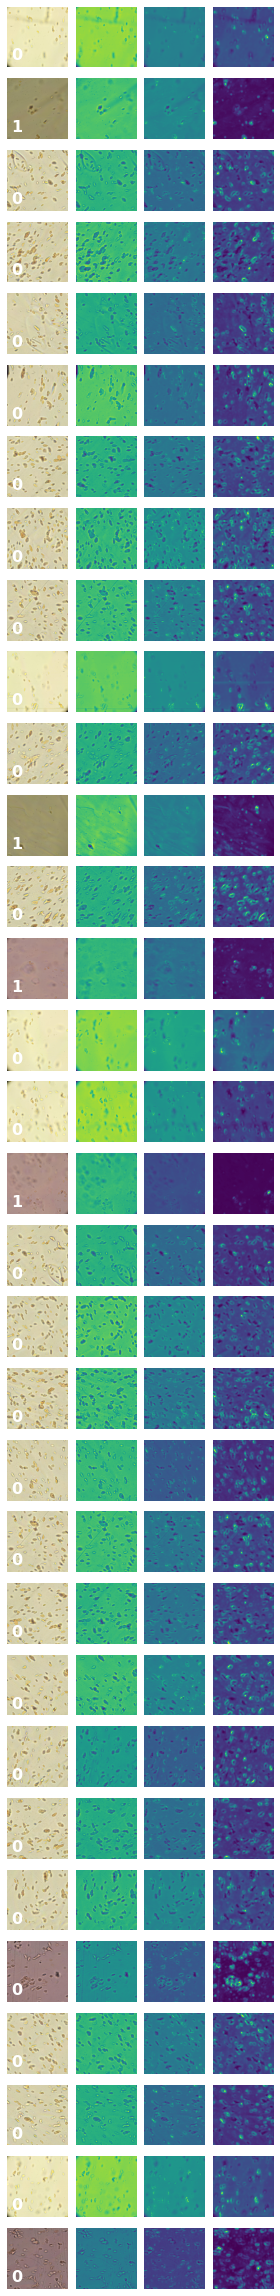

In [23]:
#    Visualize the predictions from each submodel
# -------------------------------------------------------------------- #

OVERWRITE = True

# We will visualize each image (32) prediction from each submodel (3) along with the original, but we will select only one random/first filter from each submodel.

# NOTE: texts are currently hidden, as the figure, as is, is unlikely to be unused for publications.

# create a figure with 32 (batch) height and 4 (submodel + original) width
vis_fig = plt.figure(figsize=(len(vis_predictions), len(image_batch)))
subplot_loc = 1
for i in range(len(image_batch)): # goes through each image, rows
    for j in range(len(vis_predictions)): # goes through each submodel, columns
        # provide the location for the subplot
        plt.subplot(len(image_batch), len(vis_predictions), subplot_loc)
        # plot the image within the subplot
        if j == 0: # visualize all 3 channels for originial image
            plt.imshow(vis_predictions[j][i,:,:,:]) # plot the image
            # add image numbers to the left of the first column
            # position text 10% left of the image x-size, and 50% down the image y-size
            # plt.text(-0.1*vis_predictions[j].shape[1], 0.5*vis_predictions[j].shape[2], str(i), fontsize=10, ha='right', va='center') # label the image
            # add image_label to the images in first row
            plt.text(0.15*vis_predictions[j].shape[1], 0.8*vis_predictions[j].shape[2], str(label_batch[i]), fontsize=16, color='#fff', fontweight='bold', ha='center', va='center')
        else: # visualize the mean of all channels for visualization images
            plt.imshow(np.mean(vis_predictions[j][i,:,:,:], axis=-1), cmap='viridis') # plot the image
        # if i == 0:
        #     if j == 0:
        #         plt.text(0.5*vis_predictions[j].shape[1], -0.1*vis_predictions[j].shape[2], 'original', fontsize=10, ha='center', va='bottom')
        #     else:
        #         plt.text(0.5*vis_predictions[j].shape[1], -0.1*vis_predictions[j].shape[2], 'layer '+str(j), fontsize=10, ha='center', va='bottom')
        plt.axis('off')
        subplot_loc += 1
# set font for the figure
plt.rcParams['font.family'] = 'Arial'
plt.tight_layout()
plt.savefig(Path(EXP_FOLDER, 'prediction_visualizations.png'), dpi=500) if OVERWRITE else None # 500 for each inch will closely match the pixel size of the original image
plt.show()

### Logs

In [18]:
# ============================================================================ #
#    SAVE A DESCRIPTION FILE AND THIS NOTEBOOK
# ============================================================================ #

# IS ALWAYS OVERWRITTEN

# Create a string with the various parameters
experiment_description = '\n'.join([
    'STUDY = ' + str(STUDY_FOLDER.name),
    'EXPERIMENT = ' + str(EXP_FOLDER.name),
    'DATASET = ' + str(split_dataset_path.name),
    'IMAGE SIZE = ' + str(IMAGE_SIZE),
    'BATCH SIZE = ' + str(BATCH_SIZE),
    'LEARNING RATE = ' + str(LEARNING_RATE),
    'EXPERIMENT NAME = ' + str(EXP_NAME),
    'EXPERIMENT SHORT NAME = ' + str(EXP_SHORT_NAME),
    '\n',
    ' INFORMATION ABOUT TVT DATASETS',
    '-'*80,
    'TRAINING SET = ' + str(train_gen.n) + ' (batches = ' + str(len(train_gen)) + ')',
    'VALIDATION SET = ' + str(val_gen.n) + ' (batches = ' + str(len(val_gen)) + ')',
    'TEST SET = ' + str(test_gen.n) + ' (batches = ' + str(len(test_gen)) + ')',
    'CLASSES = ' + str(train_gen.class_indices),
    'TVT Distribution = '+str(tvt_dist),
    '\n'
    ' MODEL SUMMARY',
    '-'*80,
    'MODEL ID = ' + MODEL_ID,
    ''.join([layer.name + '(' + layer.__class__.__name__ + ') | shape = ' + str(layer.output_shape) + ' | params = ' + str(layer.count_params()) + '\n' for layer in model.layers]),
    'Total params = '+str(model.count_params()),
    '\n',
    ' TRAINING',
    '-'*80,
    'EPOCHS = ' + str(len(history)),
    'KEY VALUES',
    ''.join(history.round(3).iloc[::10,1:].to_string()),
    '\n',
    ' CALCULATIONS',
    '-'*80,
    'THRESHOLDS PASSED = '+str(THRESHOLDS).replace('\n', ''),
    'VAL FPR = '+str(cmroc_val['fpr']).replace('\n', ''),
    'VAL TPR = '+str(cmroc_val['tpr']).replace('\n', ''),
    'TEST FPR = '+str(cmroc_test['fpr']).replace('\n', ''),
    'TEST TPR = '+str(cmroc_test['tpr']).replace('\n', ''),
    'VAL BEST THRESHOLD = '+str(THRESHOLDS[cmroc_val['best index']]),
    'TEST BEST THRESHOLD = '+str(THRESHOLDS[cmroc_test['best index']]),
    'VAL BEST CM = '+str(cmroc_val['best cm']).replace('\n', ''),
    'TEST BEST CM = '+str(cmroc_test['best cm']).replace('\n', ''),
    'TEST CONSTRAINED CM = '+str(cmroc_test_constrained['best cm']).replace('\n', ''),
    'VAL ACCURACY = '+str(np.around(cmroc_val['accuracy'][cmroc_val['best index']]*100, decimals=3))+' %',
    'TEST ACCURACY = '+str(np.around(cmroc_test['accuracy'][cmroc_test['best index']]*100, decimals=3))+' %',
    'TEST CONSTRAINED ACCURACY = '+str(np.around(cmroc_test_constrained['accuracy'][cmroc_test_constrained['best index']]*100, decimals=3))+' %'
])
#print(experiment_description)
# save description file
with open(Path(EXP_FOLDER, 'description.txt'), 'w') as f:
    f.write(experiment_description)

In [19]:
#    SAVE THIS NOTEBOOK
# -------------------------------------------------------------------- #

# Note that there is no way to get the name of the current Jupyter notebook.
_ = shutil.copy2('ML experiment (generic).ipynb', Path(EXP_FOLDER, EXP_ID+' notebook.ipynb'))